# **LLama 3.1-8B (base version)**

Code was adapted based on an example from [Link to Source](https://github.com/adidror005/youtube-videos/blob/main/old_videos/LLAMA_3_Fine_Tuning_for_Sequence_Classification_Actual_Video.ipynb)

## **2 Labels only, Scale (Logits/Probability)**

# **Llama**


### Big Picture Overview of Parameter Efficient Fine Tuning Methods like LoRA and QLoRA Fine Tuning for Sequence Classification

**The Essence of Fine-tuning**
- LLMs are pre-trained on vast amounts of data for broad language understanding.
- Fine-tuning is crucial for specializing in specific domains or tasks, involving adjustments with smaller, relevant datasets.

**Model Fine-tuning with PEFT: Exploring LoRA and QLoRA**
- Traditional fine-tuning is resource-intensive; PEFT (Parameter Efficient Fine-tuning) makes the process faster and less demanding.
- Focus on two PEFT methods: LoRA and QLoRA.

**The Power of PEFT**
- PEFT modifies only a subset of the LLM's parameters, enhancing speed and reducing memory demands, making it suitable for less powerful devices.

**LoRA: Efficiency through Adapters**
- **Low-Rank Adaptation (LoRA):** Injects small trainable adapters into the pre-trained model.
- **Equation:** For a weight matrix $W$, LoRA approximates $W = W_0 + BA$, where $W_0$ is the original weight matrix, and $BA$ represents the low-rank modification through trainable matrices $B$ and $A$.
- Adapters learn task nuances while keeping the majority of the LLM unchanged, minimizing overhead.

**QLoRA: Compression and Speed**
- **Quantized LoRA (QLoRA):** Extends LoRA by quantizing the model’s weights, further reducing size and enhancing speed.
- **Innovations in QLoRA:**
  1. **4-bit Quantization:** Uses a 4-bit data type, NormalFloat (NF4), for optimal weight quantization, drastically reducing memory usage.
  2. **Low-Rank Adapters:** Fine-tuned with 16-bit precision to effectively capture task-specific nuances.
  3. **Double Quantization:** Reduces quantization constants from 32-bit to 8-bit, saving additional memory without accuracy loss.
  4. **Paged Optimizers:** Manages memory efficiently during training, optimizing for large tasks.

**Why PEFT Matters**
- **Rapid Learning:** Speeds up model adaptation.
- **Smaller Footprint:** Eases deployment with reduced model size.
- **Edge-Friendly:** Fits better on devices with limited resources, enhancing accessibility.

**Conclusion**
- PEFT methods like LoRA and QLoRA revolutionize LLM fine-tuning by focusing on efficiency, facilitating faster adaptability, smaller models, and broader device compatibility.

***

### Fine-tuning for Sentiment Analysis Classification:


#### 1. Text Generation with Sentiment Label as part of text
- **Approach**: Train the model to generate text that naturally appends the sentiment label at the end.
- **Input**: "TSLA slashes model Y prices ======"
- **Output**: "TSLA slashes model Y prices ====== Bearish"
- **Use Case**: This method is useful for applications requiring continuous text output that includes embedded sentiment analysis, such as interactive chatbots or automated content creation tools.


#### 2. Sequence Classification Head
- **Approach**: Add a sequence classification head (linear layer) on top of the LLaMa Model transformer. This setup is similar to GPT-2 and focuses on classifying the sentiment based on the last relevant token in the sequence.
    - **Token Positioning**:
        - **With pad_token_id**: The model identifies and ignores padding tokens, using the last non-padding token for classification.
        - **Without pad_token_id**: It defaults to the last token in each sequence.
        - **inputs_embeds**: If embeddings are directly passed (without input_ids), the model cannot identify padding tokens and takes the last embedding in each sequence as the input for classification.
- **Input**: Specific sentences (e.g., "TSLA slashes Model Y prices").
- **Output**: Direct sentiment classification (e.g., "Bearish").
- **Training Objective**: Minimize cross-entropy loss between the predicted and the actual sentiment labels.

https://huggingface.co/docs/transformers/main/en/model_doc/llama

### Peft Configs
* Bits and bytes config for quantization
* Lora config for lora

### Going to use Hugginface Transformers trainer class: Main componenents
* Hugging face dataset (for train + eval)
* Data collater
* Compute Metrics
* Class weights since we use custom trainer and also custom weighted loss..
* trainingArgs: like # epochs, learning rate, weight decay etc..




# **Set Up**

In [1]:
# install packages
!pip install -U bitsandbytes
!pip install -U transformers
!pip install -U accelerate
!pip install -U peft
!pip install -U trl
!pip install pyarrow==18.1.0
!pip install evaluate
!pip install --upgrade wandb
!pip install adapter-transformers

  Using cached bitsandbytes-0.45.5-py3-none-manylinux_2_24_x86_64.whl.metadata (5.0 kB)
Using cached bitsandbytes-0.45.5-py3-none-manylinux_2_24_x86_64.whl (76.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 80.6 MB/s eta 0:00:00:00:01:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.2
    Uninstalling transformers-4.51.2:
      Successfully uninstalled transformers-4.51.2
  Using cached accelerate-1.6.0-py3-none-any.whl.metadata (19 kB)
Using cached accelerate-1.6.0-py3-none-any.whl (354 kB)
  Using cached peft-0.15.1-py3-none-any.whl.metadata (13 kB)
Using cached peft-0.15.1-py3-none-any.whl (411 kB)
  Using cached trl-0.16.1-py3-none-any.whl.metadata (12 kB)
  Using cached datasets-3.5.0-py3-none-any.whl.metadata (19 kB)
  Using cached rich-14.0.0-py3-none-any.whl.metadata (18 kB)
  Using cached pyarrow-19.0.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (3.3 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 

In [2]:
# import packages

import numpy as np
import pandas as pd
import os
import random
import evaluate
import functools # ??
from tqdm import tqdm
import bitsandbytes as bnb
import wandb

import torch
import torch.nn as nn
import torch.nn.functional as F

from datasets import Dataset, DatasetDict
from peft import LoraConfig, PeftConfig, prepare_model_for_kbit_training, get_peft_model

from trl import SFTTrainer
from trl import setup_chat_format

import transformers
from transformers import (AutoModelForCausalLM,
                          AutoModelForSequenceClassification,
                        AutoTokenizer,
                        AutoModel,
                          BitsAndBytesConfig, 
                          TrainingArguments, 
                            Trainer,
                            DataCollatorWithPadding,
                          pipeline, 
                          logging)

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix,
                            f1_score, balanced_accuracy_score)

from peft import PeftModel

from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, f1_score, roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np



In [3]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

torch.cuda.empty_cache()
torch.cuda.is_available()

True

In [4]:
# Hugging face access

from huggingface_hub import login
with open("../../../../login/hf_key.txt", 'r') as f: 
    HF_TOKEN = str(f.read())
    
login(token = HF_TOKEN)

In [5]:
# wandb

with open("../../../../login/wandb.txt", 'r') as f: 
    WB_TOKEN = str(f.read())

wandb.login(key=WB_TOKEN)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/jovyan/.netrc
wandb: Currently logged in as: elena-solar (elena-solar-university-of-konstanz) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# **Data**

In [6]:
# loading the data
import pandas as pd
data = pd.read_csv("../../../../data/debagree_new_preprocessing_com_rep.csv")
data = data[["label", "body_parent", "body_child", "msg_id_parent", "msg_id_child", "subreddit", "datetime", "exact_time"]].sort_values(by = "exact_time").reset_index(drop = True)

# keep integer labels
data['target'] = data['label']

# for readability, recode labels
int_to_label = {2: "agree", 1 : "neutral", 0 : "disagree"}
data.replace({"label": int_to_label}, inplace = True)

data

,label,body_parent,body_child,msg_id_parent,msg_id_child,subreddit,datetime,exact_time,target
0,neutral,"I live in rural Saskatchewan, Canada. We have ...",I'm in NE USA we've had 3 in two years...all e...,cnddov1,cndj2gv,climate,03/01/2015 23:18,1420327135,1
1,neutral,"I live in rural Saskatchewan, Canada. We have ...",One hundred year flood just means a one in one...,cnddov1,cndkpy7,climate,04/01/2015 00:10,1420330231,1
2,neutral,Convince her of what? That it's happening or t...,That anthropocentric climate change is actuall...,cndnlrd,cndnsxt,climate,04/01/2015 01:45,1420335952,1
3,disagree,I think this prediction is about as valid as s...,It's January. Literally no one said it would b...,cndl5x4,cndybsy,climate,04/01/2015 08:01,1420358465,0
4,disagree,"Mann hasn't been honest in decades, so I'm cur...",There have been a dozen re-constructions of Ma...,cne462t,cne89ej,climate,04/01/2015 17:45,1420393544,0
...,...,...,...,...,...,...,...,...,...
42838,neutral,Not trying to spark an argument but a legitima...,Keeping in mind that the Palestinians killed m...,gyo197v,gyotff1,Republican,19/05/2021 12:36,1621427788,1
42839,agree,Y'all saw Guilianis hail Mary right? Get his s...,"Same I want these assholes in jail, full stop....",gynfsu4,gyp3u39,democrats,19/05/2021 13:56,1621432578,2
42840,agree,Why don't I see ads holding Republicans accoun...,"Yeah, I agree with the goal of this post but n...",gyn6nzm,gyp5vzw,democrats,19/05/2021 14:11,1621433471,2
42841,agree,How about ... no? This is strange. Community o...,"I know, it feels strange too. We wouldn't hold...",gyp71o7,gyp7en6,BlackLivesMatter,19/05/2021 14:21,1621434116,2


***
***

### **Text Length Checks**

In [7]:
data['parent_len'] = data['body_parent'].apply(lambda x: len(x.split()))
data['child_len'] = data['body_child'].apply(lambda x: len(x.split()))
data

,label,body_parent,body_child,msg_id_parent,msg_id_child,subreddit,datetime,exact_time,target,parent_len,child_len
0,neutral,"I live in rural Saskatchewan, Canada. We have ...",I'm in NE USA we've had 3 in two years...all e...,cnddov1,cndj2gv,climate,03/01/2015 23:18,1420327135,1,17,21
1,neutral,"I live in rural Saskatchewan, Canada. We have ...",One hundred year flood just means a one in one...,cnddov1,cndkpy7,climate,04/01/2015 00:10,1420330231,1,17,58
2,neutral,Convince her of what? That it's happening or t...,That anthropocentric climate change is actuall...,cndnlrd,cndnsxt,climate,04/01/2015 01:45,1420335952,1,12,51
3,disagree,I think this prediction is about as valid as s...,It's January. Literally no one said it would b...,cndl5x4,cndybsy,climate,04/01/2015 08:01,1420358465,0,18,12
4,disagree,"Mann hasn't been honest in decades, so I'm cur...",There have been a dozen re-constructions of Ma...,cne462t,cne89ej,climate,04/01/2015 17:45,1420393544,0,13,21
...,...,...,...,...,...,...,...,...,...,...,...
42838,neutral,Not trying to spark an argument but a legitima...,Keeping in mind that the Palestinians killed m...,gyo197v,gyotff1,Republican,19/05/2021 12:36,1621427788,1,29,39
42839,agree,Y'all saw Guilianis hail Mary right? Get his s...,"Same I want these assholes in jail, full stop....",gynfsu4,gyp3u39,democrats,19/05/2021 13:56,1621432578,2,83,26
42840,agree,Why don't I see ads holding Republicans accoun...,"Yeah, I agree with the goal of this post but n...",gyn6nzm,gyp5vzw,democrats,19/05/2021 14:11,1621433471,2,16,79
42841,agree,How about ... no? This is strange. Community o...,"I know, it feels strange too. We wouldn't hold...",gyp71o7,gyp7en6,BlackLivesMatter,19/05/2021 14:21,1621434116,2,17,39


In [12]:
print("Parent Max: ", data['parent_len'].max())
print("Child Max: ", data['child_len'].max())

Parent Max:  99
Child Max:  99


***
***

In [8]:
# adapt true labels
labels_2 = []
target_new = []

for idx, row in data.iterrows():
    if row['label'] in ['neutral', 'agree']:
        labels_2.append('no_disagreement')
        target_new.append(0)
    else:
        labels_2.append('disagree')
        target_new.append(1)
        
data['label_2'] = labels_2
data['target'] = target_new
data

,label,body_parent,body_child,msg_id_parent,msg_id_child,subreddit,datetime,exact_time,target,label_2
0,neutral,"I live in rural Saskatchewan, Canada. We have ...",I'm in NE USA we've had 3 in two years...all e...,cnddov1,cndj2gv,climate,03/01/2015 23:18,1420327135,0,no_disagreement
1,neutral,"I live in rural Saskatchewan, Canada. We have ...",One hundred year flood just means a one in one...,cnddov1,cndkpy7,climate,04/01/2015 00:10,1420330231,0,no_disagreement
2,neutral,Convince her of what? That it's happening or t...,That anthropocentric climate change is actuall...,cndnlrd,cndnsxt,climate,04/01/2015 01:45,1420335952,0,no_disagreement
3,disagree,I think this prediction is about as valid as s...,It's January. Literally no one said it would b...,cndl5x4,cndybsy,climate,04/01/2015 08:01,1420358465,1,disagree
4,disagree,"Mann hasn't been honest in decades, so I'm cur...",There have been a dozen re-constructions of Ma...,cne462t,cne89ej,climate,04/01/2015 17:45,1420393544,1,disagree
...,...,...,...,...,...,...,...,...,...,...
42838,neutral,Not trying to spark an argument but a legitima...,Keeping in mind that the Palestinians killed m...,gyo197v,gyotff1,Republican,19/05/2021 12:36,1621427788,0,no_disagreement
42839,agree,Y'all saw Guilianis hail Mary right? Get his s...,"Same I want these assholes in jail, full stop....",gynfsu4,gyp3u39,democrats,19/05/2021 13:56,1621432578,0,no_disagreement
42840,agree,Why don't I see ads holding Republicans accoun...,"Yeah, I agree with the goal of this post but n...",gyn6nzm,gyp5vzw,democrats,19/05/2021 14:11,1621433471,0,no_disagreement
42841,agree,How about ... no? This is strange. Community o...,"I know, it feels strange too. We wouldn't hold...",gyp71o7,gyp7en6,BlackLivesMatter,19/05/2021 14:21,1621434116,0,no_disagreement


In [9]:
# make text

def create_training_data(data):

    result = []

    for idx, row in data.iterrows():
        #system_prompt = """You are a classification Chatbot. Given a comment and a reply, you classify whether the reply disagrees with the comment, or not. You only reply with either "disagree" or "no_disagreement" and nothing else."""
        comment = row["body_parent"]
        reply = row["body_child"]
        label = row["label_2"]
        target = row["target"]
        result.append({'comment' : comment, 'reply': reply, 'label' : label, 'target' : target})
    
    return result

# save data
df = pd.DataFrame(create_training_data(data))
df

,comment,reply,label,target
0,"I live in rural Saskatchewan, Canada. We have ...",I'm in NE USA we've had 3 in two years...all e...,no_disagreement,0
1,"I live in rural Saskatchewan, Canada. We have ...",One hundred year flood just means a one in one...,no_disagreement,0
2,Convince her of what? That it's happening or t...,That anthropocentric climate change is actuall...,no_disagreement,0
3,I think this prediction is about as valid as s...,It's January. Literally no one said it would b...,disagree,1
4,"Mann hasn't been honest in decades, so I'm cur...",There have been a dozen re-constructions of Ma...,disagree,1
...,...,...,...,...
42838,Not trying to spark an argument but a legitima...,Keeping in mind that the Palestinians killed m...,no_disagreement,0
42839,Y'all saw Guilianis hail Mary right? Get his s...,"Same I want these assholes in jail, full stop....",no_disagreement,0
42840,Why don't I see ads holding Republicans accoun...,"Yeah, I agree with the goal of this post but n...",no_disagreement,0
42841,How about ... no? This is strange. Community o...,"I know, it feels strange too. We wouldn't hold...",no_disagreement,0


In [10]:
df['prompt'] = None

def make_prompt(row):

    prompt = "Comment: " + row["comment"] + "; Reply: " + row["reply"]

    return prompt



df['prompt'] = df.apply(lambda row: make_prompt(row), axis = 1)
df

,comment,reply,label,target,prompt
0,"I live in rural Saskatchewan, Canada. We have ...",I'm in NE USA we've had 3 in two years...all e...,no_disagreement,0,"Comment: I live in rural Saskatchewan, Canada...."
1,"I live in rural Saskatchewan, Canada. We have ...",One hundred year flood just means a one in one...,no_disagreement,0,"Comment: I live in rural Saskatchewan, Canada...."
2,Convince her of what? That it's happening or t...,That anthropocentric climate change is actuall...,no_disagreement,0,Comment: Convince her of what? That it's happe...
3,I think this prediction is about as valid as s...,It's January. Literally no one said it would b...,disagree,1,Comment: I think this prediction is about as v...
4,"Mann hasn't been honest in decades, so I'm cur...",There have been a dozen re-constructions of Ma...,disagree,1,"Comment: Mann hasn't been honest in decades, s..."
...,...,...,...,...,...
42838,Not trying to spark an argument but a legitima...,Keeping in mind that the Palestinians killed m...,no_disagreement,0,Comment: Not trying to spark an argument but a...
42839,Y'all saw Guilianis hail Mary right? Get his s...,"Same I want these assholes in jail, full stop....",no_disagreement,0,Comment: Y'all saw Guilianis hail Mary right? ...
42840,Why don't I see ads holding Republicans accoun...,"Yeah, I agree with the goal of this post but n...",no_disagreement,0,Comment: Why don't I see ads holding Republica...
42841,How about ... no? This is strange. Community o...,"I know, it feels strange too. We wouldn't hold...",no_disagreement,0,Comment: How about ... no? This is strange. Co...


### Train/Test Split

Make train/val/test split by time order!

In [11]:
# Split the DataFrame
train_size = 0.8
eval_size = 0.1

# Determine splitting indexes (ordered by time)
train_end = int(train_size * len(df))
eval_end = train_end + int(eval_size * len(df))

# Split the data
X_train = df[:train_end]
X_eval = df[train_end:eval_end]
X_test = df[eval_end:]

### Convert from Pandas DataFrame to Hugging Face Dataset
* Also let's shuffle the training set.
* We put the components train,val,test into a DatasetDict so we can access them later with HF trainer.
* Later we will add a tokenized dataset

In [12]:
X_train_dataset = Dataset.from_pandas(X_train.drop('label', axis = 1))
X_eval_dataset = Dataset.from_pandas(X_eval.drop('label', axis = 1))
X_test_dataset = Dataset.from_pandas(X_test.drop('label', axis = 1))

X_test_dataset

Dataset({
    features: ['comment', 'reply', 'target', 'prompt'],
    num_rows: 4285
})

Shuffle training data --> apparently this helps with performance

In [13]:
X_train_dataset_shuffle = X_train_dataset.shuffle(seed = 42)

In [14]:
dataset = DatasetDict({
    'train' : X_train_dataset_shuffle,
    'val' : X_eval_dataset,
    'test' : X_test_dataset
})
dataset

DatasetDict({
    train: Dataset({
        features: ['comment', 'reply', 'target', 'prompt'],
        num_rows: 34274
    })
    val: Dataset({
        features: ['comment', 'reply', 'target', 'prompt'],
        num_rows: 4284
    })
    test: Dataset({
        features: ['comment', 'reply', 'target', 'prompt'],
        num_rows: 4285
    })
})

Check distributions

In [15]:
X_train.target.value_counts(normalize = True)

target
0    0.599463
1    0.400537
Name: proportion, dtype: float64

### Class Weights

* Since our classes are not balanced let's calculate class weights based on inverse value counts
* Convert to pytorch tensor since we will need it

In [16]:
# invert the weights
class_weights = (1/X_train.target.value_counts(normalize = True).sort_index()).to_list()

# make a tensor
class_weights = torch.tensor(class_weights)

# make them sum to one
class_weights = class_weights/class_weights.sum()
class_weights

tensor([0.4005, 0.5995])

# **Load the Model**

Apparently, meta recommends the base version of the model for finetuning [source](https://www.youtube.com/watch?v=YJNbgusTSF0)

* load model with 4bit quantization (as specified in bits and bytes) and prepare model for peft training

In [17]:
model_name = "meta-llama/Llama-3.1-8B" 

### Quantization for QLoRA

In [19]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit = True, # enable 4 bit quantization
    bnb_4bit_quant_type = 'nf4', # information theoretically optimal dtype for normally distributed weights
    bnb_4bit_use_double_quant = True, # quantize quantized weights
    bnb_4bit_compute_dtype = torch.bfloat16 # optimized fp format for ML
)

### LoRA Config

In [20]:
lora_config = LoraConfig(
    r = 16, # dimensions of low-rank matrices
    lora_alpha = 8, # scaling factor (trade-off) for LoRA activations vs. pretrained weight activations
    target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj'], # where to apply LoRA to
    lora_dropout = 0.05, # drop out probability of LoRA layers, to prevent overfitting
    bias = 'none', # wether to train bias weights, set to 'none' for attention layers
    task_type = 'SEQ_CLS'
)

### Load the Model

* AutoModelForSequenceClassification --> used for classifications
* Num of labels is # of classes

In [21]:
torch.cuda.empty_cache()

In [22]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    quantization_config = quantization_config,
    num_labels = 2
)

model

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.1-8B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNor

### Function to preprocess quantized model for training

In [23]:
model = prepare_model_for_kbit_training(model)
model

LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNor

### Prepare for PEFT training

`get_peft_model()` to prepare the model for training with PEFT method such as LoRA by wrapping the base model and PEFT configuration with `get_peft_model()`

In [24]:
model = get_peft_model(model, lora_config)
model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): LlamaForSequenceClassification(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
           

# **Tokenizer**

### Since LLAMA3 pre-training doesn't have EOS token
* Set the pad_token_id to eos_token_id
* Set pad token ot eos_token

In [25]:
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space = True)

tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

### Update Model Configurations

In [26]:
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False
model.config.pretraining_pt = 1

### Apply model to get performance prior to training

**Useless, as the model will output random logits $ßto$ it has not learned anything yet**

* Use batch size 32 to vectorize and avoid memory errors

In [27]:
X_test.iloc[100]['prompt'] 

"Comment: luckily they won't retake the house. Has this piece of shit ever been on any other news channel other than FoxNews, OAN, and NewsMax? This man only speaks and care about his base, he doesn't give a shit about the rest of America.; Reply: I hope you're right but given that the GOP made gains in 2020, let's not be too overconfident 2022 won't have a red wave."

In [28]:
torch.cuda.empty_cache()

# Convert summaries to a list
sentences = X_test.prompt.tolist()

# Define the batch size
batch_size = 8  # You can adjust this based on your system's memory capacity

# Initialize an empty list to store the model outputs
all_outputs = []

# Process the sentences in batches
for i in tqdm(range(0, len(sentences), batch_size)):
    # Get the batch of sentences
    batch_sentences = sentences[i:i + batch_size]

    # Tokenize the batch
    inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Move tensors to the device where the model is (e.g., GPU or CPU)
    inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}

    # Perform inference and store the logits
    with torch.no_grad():
        outputs = model(**inputs)
        all_outputs.append(outputs['logits'])



  1%|▏         | 7/537 [00:03<04:21,  2.02it/s]


KeyboardInterrupt: 

Concatenate Outputs into a single tensor

In [43]:
final_outputs = torch.cat(all_outputs, dim=0)
final_outputs

tensor([[-2.4675, -2.4747],
        [ 2.0257,  0.0061],
        [ 0.1863,  0.3972],
        ...,
        [ 4.6069, -1.0798],
        [ 1.2376, -2.0870],
        [ 2.0624, -0.1581]], device='cuda:0')

Get **probabilities** with softmax function

In [44]:
probabilities = F.softmax(final_outputs, dim=1)
print(probabilities) 

tensor([[0.5018, 0.4982],
        [0.8828, 0.1172],
        [0.4475, 0.5525],
        ...,
        [0.9966, 0.0034],
        [0.9653, 0.0347],
        [0.9021, 0.0979]], device='cuda:0')


In [45]:
predicted_labels = probabilities.argmax(dim=1)  # Get class labels
certainty_scores = probabilities.max(dim=1).values  # Get max probability per row

In [46]:
predicted_labels
certainty_scores

tensor([0.5018, 0.8828, 0.5525,  ..., 0.9966, 0.9653, 0.9021], device='cuda:0')

Extract predictions and turn to label

In [47]:
X_test['predictions_label_initial'] = predicted_labels.cpu().numpy()
X_test['predictions_score_initial'] = certainty_scores.cpu().numpy()

X_test

/tmp/ipykernel_882/1638758842.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['predictions_label_initial'] = predicted_labels.cpu().numpy()
/tmp/ipykernel_882/1638758842.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['predictions_score_initial'] = certainty_scores.cpu().numpy()


,comment,reply,label,target,prompt,predictions_label_initial,predictions_score_initial
38604,It's so nice having a FLOTUS who's facial expr...,Melanoma's squinty cat face always looked to m...,no_disagreement,0,Comment: It's so nice having a FLOTUS who's fa...,0,0.501805
38605,Because Mitch McConnell indicated he's voting ...,I think it's worth it because the more we air ...,disagree,1,Comment: Because Mitch McConnell indicated he'...,0,0.882832
38606,How about some stimulus checks and a decent st...,"You get this was an executive action, not legi...",disagree,1,Comment: How about some stimulus checks and a ...,1,0.552526
38607,Satire feels appropriate. I'd like one dose of...,Are you saying they didn't know or understand ...,disagree,1,Comment: Satire feels appropriate. I'd like on...,0,0.909323
38608,I actually didn't want to upload these particu...,To be fair they are just reporting what Brexit...,no_disagreement,0,Comment: I actually didn't want to upload thes...,0,0.911840
...,...,...,...,...,...,...,...
42889,Not trying to spark an argument but a legitima...,Keeping in mind that the Palestinians killed m...,no_disagreement,0,Comment: Not trying to spark an argument but a...,0,0.905063
42890,Y'all saw Guilianis hail Mary right? Get his s...,"Same I want these assholes in jail, full stop....",no_disagreement,0,Comment: Y'all saw Guilianis hail Mary right? ...,0,0.973733
42891,>Why don't I see ads holding Republicans accou...,"Yeah, I agree with the goal of this post but n...",no_disagreement,0,Comment: >Why don't I see ads holding Republic...,0,0.996621
42892,How about ... no? This is strange. Community o...,"I know, it feels strange too. We wouldn't hold...",no_disagreement,0,Comment: How about ... no? This is strange. Co...,0,0.965263


In [29]:
label_dict = {0 : 'no_disagreement', 1: 'disagree'}

X_test['predictions_initial']=X_test['predictions_label_initial'].apply(lambda l:label_dict[l])
X_test#['predictions_initial']

KeyError: 'predictions_label_initial'

In [49]:
X_test['predictions_initial'].value_counts()

predictions_initial
no_disagreement    3788
disagree            502
Name: count, dtype: int64

In [34]:
X_test.to_csv("output/v4_Llama_3.1_8B_initial_X_test_2labels_scale.csv", index = False)

## **Three versions of initial performance**

$\to$ has not learned anything yet, so random!

In [50]:
X_test.label.value_counts()

label
no_disagreement    2666
disagree           1624
Name: count, dtype: int64

In [35]:
X_test_old = pd.read_csv("output/OLD_Llama_3.1_8B_initial_X_test_2labels_scale.csv")
X_test_old['predictions_initial'].value_counts()

predictions_initial
no_disagreement    3053
disagree           1237
Name: count, dtype: int64

In [36]:
X_test = pd.read_csv("output/Llama_3.1_8B_initial_X_test_2labels_scale.csv")
X_test['predictions_initial'].value_counts()

predictions_initial
no_disagreement    4040
disagree            250
Name: count, dtype: int64

In [40]:
X_test_new = pd.read_csv("output/new_1_Llama_3.1_8B_initial_X_test_2labels_scale.csv")
X_test_new['predictions_initial'].value_counts()

predictions_initial
no_disagreement    2419
disagree           1871
Name: count, dtype: int64


Why are the predicted labels now so imbalances?! Check reasons/causes!

$\to$ random logits. The model has not learned anything so far.

# **Performance**

In [23]:
def get_performance_metrics(df_test, pred_col):
  y_test = df_test.label
  y_pred = df_test[pred_col]

  print("Confusion Matrix:")
  print(confusion_matrix(y_test, y_pred))

  print("\nClassification Report:")
  print(classification_report(y_test, y_pred))

  print("Balanced Accuracy Score:", balanced_accuracy_score(y_test, y_pred))
  print("Accuracy Score:", accuracy_score(y_test, y_pred))

In [31]:
get_performance_metrics(X_test_old, 'predictions_initial')

NameError: name 'X_test_old' is not defined

In [31]:
get_performance_metrics(X_test, 'predictions_initial')

Confusion Matrix:
[[  85 1539]
 [ 165 2501]]

Classification Report:
                 precision    recall  f1-score   support

       disagree       0.34      0.05      0.09      1624
no_disagreement       0.62      0.94      0.75      2666

       accuracy                           0.60      4290
      macro avg       0.48      0.50      0.42      4290
   weighted avg       0.51      0.60      0.50      4290

Balanced Accuracy Score: 0.495224714429839
Accuracy Score: 0.6027972027972028


In [43]:
get_performance_metrics(X_test_new, 'predictions_initial')

Confusion Matrix:
[[ 667  957]
 [1204 1462]]

Classification Report:
                 precision    recall  f1-score   support

       disagree       0.36      0.41      0.38      1624
no_disagreement       0.60      0.55      0.58      2666

       accuracy                           0.50      4290
      macro avg       0.48      0.48      0.48      4290
   weighted avg       0.51      0.50      0.50      4290

Balanced Accuracy Score: 0.4795506912442396
Accuracy Score: 0.49627039627039626


# **Trainer**

* model
* tokenizer
* training arguments
* train dataset
* eval dataset
* Data Collater
* Compute Metrics
* class_weights: In our case since we are using a custom trainer so we can use a weighted loss we will subclass trainer and define the custom loss.

### Create LLAMA tokenized dataset which will house our train/val parts during the training process but after applying tokenization

In [28]:
dataset

DatasetDict({
    train: Dataset({
        features: ['comment', 'reply', 'target', 'prompt'],
        num_rows: 34274
    })
    val: Dataset({
        features: ['comment', 'reply', 'target', 'prompt'],
        num_rows: 4284
    })
    test: Dataset({
        features: ['comment', 'reply', 'target', 'prompt'],
        num_rows: 4285
    })
})

In [29]:
MAX_LEN = 512
col_to_delete = ['comment', 'reply', 'prompt']

def llama_preprocessing_function(examples):
    return tokenizer(examples['prompt'], truncation=True, max_length=MAX_LEN)

tokenized_datasets = dataset.map(llama_preprocessing_function, batched=True, remove_columns=col_to_delete)
tokenized_datasets = tokenized_datasets.rename_column("target", "label")
tokenized_datasets.set_format("torch")

Map:   0%|          | 0/34274 [00:00<?, ? examples/s]

Map:   0%|          | 0/4284 [00:00<?, ? examples/s]

Map:   0%|          | 0/4285 [00:00<?, ? examples/s]

In [30]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 34274
    })
    val: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 4284
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 4285
    })
})

## Data Collator
A **data collator** prepares batches of data for training or inference in machine learning, ensuring uniform formatting and adherence to model input requirements. This is especially crucial for variable-sized inputs like text sequences.

### Functions of Data Collator

1. **Padding:** Uniformly pads sequences to the length of the longest sequence using a special token, allowing simultaneous batch processing.
2. **Batching:** Groups individual data points into batches for efficient processing.
3. **Handling Special Tokens:** Adds necessary special tokens to sequences.
4. **Converting to Tensor:** Transforms data into tensors, the required format for machine learning frameworks.

### `DataCollatorWithPadding`

The `DataCollatorWithPadding` specifically manages padding, using a tokenizer to ensure that all sequences are padded to the same length for consistent model input.

- **Syntax:** `collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)`
- **Purpose:** Automatically pads text data to the longest sequence in a batch, crucial for models like BERT or GPT.
- **Tokenizer:** Uses the provided `tokenizer` for sequence processing, respecting model-specific vocabulary and formatting rules.

This collator is commonly used with libraries like Hugging Face's Transformers, facilitating data preprocessing for various NLP models.


In [31]:
collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)


### Metrics for Evaluation

In [32]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'balanced_accuracy' : balanced_accuracy_score(predictions, labels),'accuracy':accuracy_score(predictions,labels)}


### Define Custom Trainer
* We will have a custom loss function that deals with the class weights and have class weights as additional argument in constructor

In [33]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        # Ensure label_weights is a tensor
        if class_weights is not None:
            self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.args.device)
        else:
            self.class_weights = None

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # Extract labels and convert them to long type for cross_entropy
        labels = inputs.pop("labels").long()

        # Forward pass
        outputs = model(**inputs)

        # Extract logits assuming they are directly outputted by the model
        logits = outputs.get('logits')

        # Compute custom loss with class weights for imbalanced data handling
        if self.class_weights is not None:
            loss = F.cross_entropy(logits, labels, weight=self.class_weights)
        else:
            loss = F.cross_entropy(logits, labels)

        return (loss, outputs) if return_outputs else loss


***
### Training Arguments --> 5 epochs!

In [58]:
training_args = TrainingArguments(
    output_dir = 'Llama_3.1_8B_training_2labels_scale',
    learning_rate = 1e-4,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8,
    num_train_epochs = 5, # checked up to 5, but overfitting
    weight_decay = 0.01,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True
)

/opt/conda/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [59]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_datasets['train'],
    eval_dataset = tokenized_datasets['val'],
    tokenizer = tokenizer,
    data_collator = collate_fn,
    compute_metrics = compute_metrics,
    class_weights=class_weights,
)

/tmp/ipykernel_882/37245773.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/tmp/ipykernel_882/37245773.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.args.device)


### Run the Trainer

In [60]:
train_result = trainer.train()

# metrics
metrics = train_result.metrics
max_train_samples = len(X_train)
metrics["train_samples"] = min(max_train_samples, len(X_train))
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

trainer.model.eval()
# save
trainer.model.save_pretrained("Llama_3.1_8B_saved_model_2labels_scale")

trainer.tokenizer.save_pretrained("Llama_3.1_8B_saved_model_2labels_scale")
trainer.model.config.save_pretrained("Llama_3.1_8B_saved_model_2labels_scale")

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


/opt/conda/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Balanced Accuracy,Accuracy
1,0.464300,0.443172,0.812316,0.821870
2,0.418500,0.446552,0.815787,0.826533
3,0.367100,0.547217,0.808032,0.820937
4,0.306700,0.704391,0.810855,0.823735
5,0.206600,0.952339,0.808707,0.820937


/opt/conda/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/conda/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/conda/lib/python3.11/site-packages/torch/_dynamo/

***** train metrics *****
  epoch                    =          5.0
  total_flos               = 1021181669GF
  train_loss               =       0.3661
  train_runtime            =   8:32:26.73
  train_samples            =        34315
  train_samples_per_second =         5.58
  train_steps_per_second   =        0.698


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


***
### Training Arguments --> 2 epochs!

In [34]:
training_args = TrainingArguments(
    output_dir = 'final_Llama_3.1_8B_training_2labels_scale',
    learning_rate = 1e-4,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8,
    num_train_epochs = 2, # checked up to 5, but overfitting
    weight_decay = 0.01,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True
)

/opt/conda/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [35]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_datasets['train'],
    eval_dataset = tokenized_datasets['val'],
    tokenizer = tokenizer,
    data_collator = collate_fn,
    compute_metrics = compute_metrics,
    class_weights=class_weights,
)

/tmp/ipykernel_341/37245773.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/tmp/ipykernel_341/37245773.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.args.device)


### Run the Trainer

In [36]:
train_result = trainer.train()

# metrics
metrics = train_result.metrics
max_train_samples = len(X_train)
metrics["train_samples"] = min(max_train_samples, len(X_train))
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

# set to evaulation mode
trainer.model.eval() 


# save LoRa adapters
trainer.model.save_pretrained("final_Llama_3.1_8B_saved_model_2labels_scale")

tokenizer.save_pretrained("final_Llama_3.1_8B_saved_model_2labels_scale")
trainer.model.config.save_pretrained("final_Llama_3.1_8B_saved_model_2labels_scale")

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


/opt/conda/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Balanced Accuracy,Accuracy
1,0.455300,0.449319,0.791646,0.799486
2,0.379800,0.432709,0.813033,0.825864


/opt/conda/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


***** train metrics *****
  epoch                    =         2.0
  total_flos               = 401367894GF
  train_loss               =      0.4498
  train_runtime            =  3:21:55.79
  train_samples            =       34274
  train_samples_per_second =       5.658
  train_steps_per_second   =       0.707


### Save the model

In [64]:
metrics = train_result.metrics
max_train_samples = len(X_train)
metrics["train_samples"] = min(max_train_samples, len(X_train))
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =         2.0
  total_flos               = 409156285GF
  train_loss               =      0.3899
  train_runtime            =  3:25:17.47
  train_samples            =       34315
  train_samples_per_second =       5.572
  train_steps_per_second   =       0.697


***
***
# **Reimport**

1. base mode
2. then fin etuned adapters
3. merge

In [18]:
model_name = "meta-llama/Llama-3.1-8B" 


quantization_config = BitsAndBytesConfig(
    load_in_4bit = True, # enable 4 bit quantization
    bnb_4bit_quant_type = 'nf4', # information theoretically optimal dtype for normally distributed weights
    bnb_4bit_use_double_quant = True, # quantize quantized weights
    bnb_4bit_compute_dtype = torch.bfloat16 # optimized fp format for ML
)
 
adapter_path = "final_Llama_3.1_8B_saved_model_2labels_scale"

# Load the base model first
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    quantization_config = quantization_config
)


# Load the LoRA adapter on top of it
model = PeftModel.from_pretrained(model, adapter_path)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("final_Llama_3.1_8B_saved_model_2labels_scale", add_prefix_space=True)

tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id  
model.config.use_cache = False 
model.config.pretraining_pt = 1

# move model to gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

model.to(device) 

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.1-8B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## **Evaluation**

In [61]:
# dictionary for conversions
label_dict = {1: "disagree", 0 : "no_disagreement"}


def make_predictions(model,df_test, thresh):
    
    model.eval()
    # Convert summaries to a list
    sentences = df_test.prompt.tolist()
    
    # Define the batch size
    batch_size = 32  # You can adjust this based on your system's memory capacity
    
    # Initialize an empty list to store the model outputs
    all_outputs = []
    
    # Process the sentences in batches
    for i in tqdm(range(0, len(sentences), batch_size)):
      # Get the batch of sentences
      batch_sentences = sentences[i:i + batch_size]
    
      # Tokenize the batch
      inputs = tokenizer(batch_sentences, return_tensors="pt", padding = True, truncation=True, max_length=512) #return_tensors="pt", padding=True,
    
      # Move tensors to the device where the model is (e.g., GPU or CPU)
      inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}
    
      # Perform inference and store the logits
      with torch.no_grad():
          outputs = model(**inputs)
          all_outputs.append(outputs['logits'])
          
          
    final_outputs = torch.cat(all_outputs, dim=0)
    probabilities = F.softmax(final_outputs, dim=1)

    probs_disagree = probabilities[:, 1].cpu().numpy()  # index 1 = 'disagree'
    predicted_labels = (probs_disagree > thresh).long()  # binary prediction
    certainty_scores = torch.max(probabilities, dim=1).values
    
    df_test['predictions_label_ft'] = predicted_labels.cpu().numpy()
    df_test['predictions_score_ft'] = certainty_scores.cpu().numpy()
    df_test['predictions_ft'] = df_test['predictions_label_ft'].apply(lambda l:label_dict[l])
    
    return df_test, probs_disagree
  


X_test, probs_disagree = make_predictions(model, X_test, thresh = 0.5)



 15%|█▍        | 20/134 [00:05<00:33,  3.37it/s]


KeyboardInterrupt: 

In [41]:
X_test.to_csv("output/Llama_3.1_8B_ft_X_test_2labels_scale.csv", index = False)

In [42]:
X_test = pd.read_csv("output/Llama_3.1_8B_ft_X_test_2labels_scale.csv")

### Performance

In [ ]:
def get_performance_metrics(df_test, pred_col):
  y_test = df_test.label
  y_pred = df_test[pred_col]

  print("Confusion Matrix:")
  print(confusion_matrix(y_test, y_pred))

  print("\nClassification Report:")
  print(classification_report(y_test, y_pred))

  print("Balanced Accuracy Score:", balanced_accuracy_score(y_test, y_pred))
  print("Accuracy Score:", accuracy_score(y_test, y_pred))

In [43]:
get_performance_metrics(X_test, 'predictions_ft')

Confusion Matrix:
[[1335  289]
 [ 507 2154]]

Classification Report:
                 precision    recall  f1-score   support

       disagree       0.72      0.82      0.77      1624
no_disagreement       0.88      0.81      0.84      2661

       accuracy                           0.81      4285
      macro avg       0.80      0.82      0.81      4285
   weighted avg       0.82      0.81      0.82      4285

Balanced Accuracy Score: 0.8157572294944491
Accuracy Score: 0.8142357059509918


In [40]:
y_test = X_test.label
y_pred = X_test['predictions_ft']

report_dict = classification_report(y_test, y_pred, output_dict=True)
df = pd.DataFrame(report_dict).transpose()

# Export to LaTeX table
latex_code = df.to_latex(float_format="%.2f", index=True, caption="Classification Report per Label")
print(latex_code)

\begin{table}
\caption{Classification Report per Label}
\begin{tabular}{lrrrr}
\toprule
 & precision & recall & f1-score & support \\
\midrule
disagree & 0.72 & 0.82 & 0.77 & 1624.00 \\
no_disagreement & 0.88 & 0.81 & 0.84 & 2661.00 \\
accuracy & 0.81 & 0.81 & 0.81 & 0.81 \\
macro avg & 0.80 & 0.82 & 0.81 & 4285.00 \\
weighted avg & 0.82 & 0.81 & 0.82 & 4285.00 \\
\bottomrule
\end{tabular}
\end{table}



In [33]:
X_test
probs_disagree

tensor([0.4248, 0.0089, 0.4534,  ..., 0.0356, 0.0112, 0.0305], device='cuda:0',
       dtype=torch.float16)

# **ROC and Precision-Recall**

In [57]:

def plot_roc_pr_curves(y_true, y_scores, threshold_points=[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]):
    
    # ROC
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # Precision-Recall
    precision, recall, pr_thresholds = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)

    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # --- ROC Curve ---
    ax1.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange', lw=2)
    ax1.plot([0, 1], [0, 1], linestyle='--', color='gray')
    
    # Annotate thresholds on ROC curve
    for thresh in threshold_points:
        idx = np.argmin(np.abs(roc_thresholds - thresh))
        ax1.plot(fpr[idx], tpr[idx], 'o', label=f'Threshold {roc_thresholds[idx]:.2f}')
        ax1.annotate(f"{roc_thresholds[idx]:.2f}", (fpr[idx], tpr[idx]), textcoords="offset points", xytext=(-10,3), ha='center', fontsize=9)
    
    ax1.set_title("ROC Curve", fontsize=14)
    ax1.set_xlabel("False Positive Rate", fontsize=12)
    ax1.set_ylabel("True Positive Rate (Recall)", fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend()

    # --- PR Curve ---
    ax2.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})', color='blue', lw=2)
    
    # Annotate thresholds on PR curve
    for thresh in threshold_points:
        idx = np.argmin(np.abs(pr_thresholds - thresh))
        ax2.plot(recall[idx], precision[idx], 'o', label=f'Threshold {pr_thresholds[idx]:.2f}')
        ax2.annotate(f"{pr_thresholds[idx]:.2f}", (recall[idx], precision[idx]), textcoords="offset points", xytext=(10,3), ha='center', fontsize=9)
    
    ax2.set_title("Precision-Recall Curve", fontsize=14)
    ax2.set_xlabel("Recall", fontsize=12)
    ax2.set_ylabel("Precision", fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend()

    plt.tight_layout()
    plt.show()

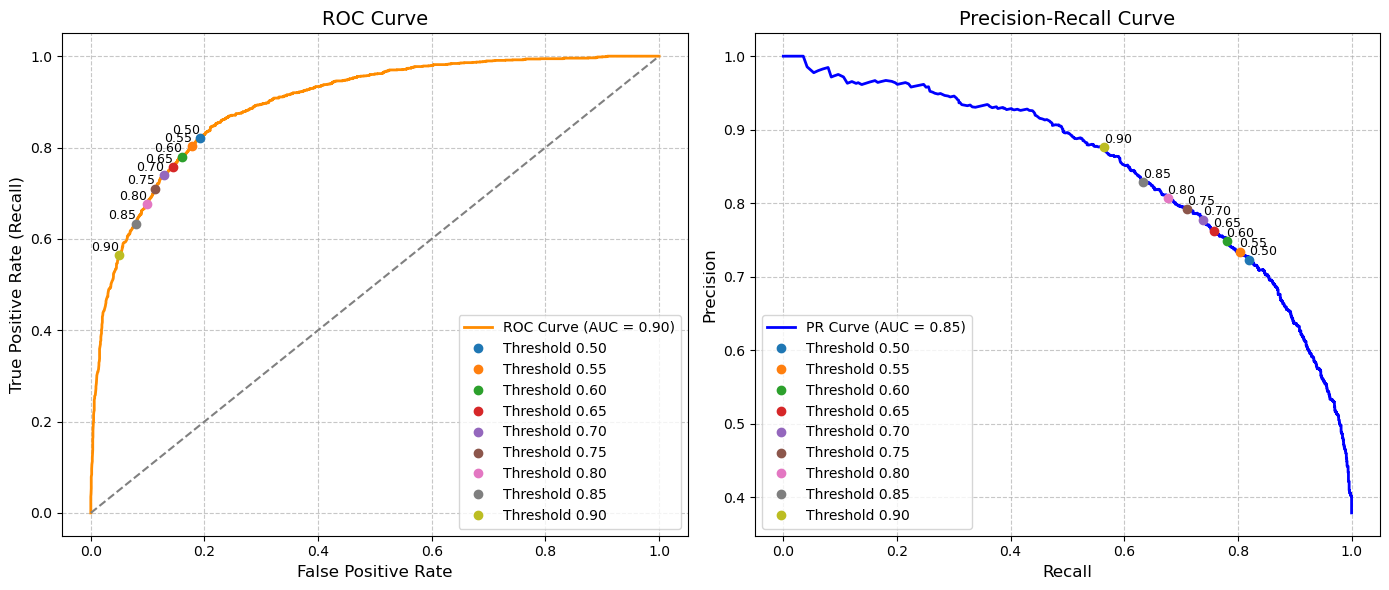

In [58]:
y_scores = probs_disagree.cpu().numpy()  
y_true = X_test['label'].apply(lambda x: 1 if x == 'disagree' else 0).values

plot_roc_pr_curves(y_true, y_scores)